# RAG From Scratch

Creating and running a local RAG pipeline from scratch.

It will be private, fast and cost-effective.

## What I'll be building:

A RAG pipeline that enables us to chat with a large PDF document (1000+ pages long).

We'll write the code to:
1. Open a PDF document (you could use almost any PDF here).
2. Format the text of the PDF textbook ready for an embedding model (this process is known as text splitting/3.chunking).
3. Embed all of the chunks of text in the textbook and turn them into numerical representation which we can store for later.
4. Build a retrieval system that uses vector search to find relevant chunks of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on passages from the textbook.

The above steps can broken down into two major sections:

1. Document preprocessing/embedding creation (steps 1-3).
2. Search and answer (steps 4-6).

## 1. Document/text processing and embedding creation

Ingredients:
* PDF document of choice (code can be adapted to other document formats)
* Embedding model of choice

Steps:
1. Import the PDF
2. Process the text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings locally

### Import PDF documents

In [3]:
import os

pdf_path = "human-nutrition-text.pdf"

In [4]:
import fitz             # Using PyMuPDF for PDF formatting
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    "Performs minor formatting on text"
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({'page_number': page_number - 41,                    # -41 because the first 41 pages are not relevant
                               "page_char_count": len(text),
                               "page_word_count": len(text.split(" ")),             # Splitting words on spaces
                               "page_sentence_count_raw": len(text.split(". ")),    # Splitting sentences on full stops followed by a space
                               "page_token_count": len(text) / 4,           # assuming 1 token is approx. 4 characters
                               "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [5]:
# Checking a random sample
pages_and_texts[385]

{'page_number': 344,
 'page_char_count': 944,
 'page_word_count': 153,
 'page_sentence_count_raw': 6,
 'page_token_count': 236.0,
 'text': 'minerals, phytonutrients, and antioxidants. At restaurants be aware  that phrases such as “cooked in vegetable oil” might mean  hydrogenated vegetable oil, and therefore trans fat.  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.  \xa0 An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http:/ 

In [6]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [7]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15
std,348.86,560.44,95.75,6.19,140.11
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.75,134.00,4.00,190.69
50%,562.50,1232.50,215.00,10.00,308.12
75%,864.25,1605.25,271.25,14.00,401.31
max,1166.00,2308.00,429.00,32.00,577.00


Why is token count important?

Token count is important as:
1. Embedding models and LLMs can't deal with infinite tokens.

For example, an embedding may have been trained to embed sequences of 384 tokens into numerical space (sentence-transformers `all-mpnet-base-v2`).

In case of LLMs, they cannot fit infinite elements in the context window.

### Further text processing (splitting pages into sentences)

2 ways to do it:
1. Splitting on ". " (what we've done)
2. Using a NLP library like spaCy

In [8]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# Create document instance as an example
doc = nlp("This is a sample sentence. This is another sample sentence")
assert(len(list(doc.sents)) == 2)           # Checking if the sentencizer is working

list(doc.sents)

[This is a sample sentence., This is another sample sentence]

In [9]:
pages_and_texts[250]

{'page_number': 209,
 'page_char_count': 1186,
 'page_word_count': 213,
 'page_sentence_count_raw': 8,
 'page_token_count': 296.5,
 'text': 'Water Concerns  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  At this point you have learned how critical water is to support  human life, how it is distributed and moved in the body, how fluid  balance and composition is maintained, and the recommended  amount of fluids a person should consume daily. In America you  have a choice of thousands of different beverages. Which should  you choose to receive the most health benefit and achieve your  recommended fluid intake?  Reading the Label  Most beverages marketed in the United States have a Nutrition  Facts panel and ingredients list, but some, such as coffee (for home  consumption), beer, and wine, do not. As with foods, beverages that  are nutrient-dense are the better choices, with the exception of  plain water, which contains few to no oth

In [10]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Ensuring all sentences are strings (default is spaCy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [11]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32
std,348.86,560.44,95.75,6.19,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### Chunking our sentences together

Chunking is the process of splitting larger pieces into smaller ones.

I'll split it into groups of 10 sentences.

What is the need for chunking?
1. So our texts are easier to filter (smaller groups of text are easier to inspect).
2. So our text chunks can fit into the embedding model context window.
3. So the contents passed to LLM can be more specific and focused.

In [12]:
num_sentence_chunk_size = 10

# E.g if len = 25, split into 10 10 5
def split_list(input_list: list[str], split_size: int = num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i: i + split_size] for i in range(0, len(input_list), split_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [13]:
# Looping through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"], split_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32,1.53
std,348.86,560.44,95.75,6.19,140.11,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00,1.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00,1.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### Splitting each chunk into its own item

By embedding each chunk of sentences into its numerical representation, we can dive deeper into the text sample that was used in our model,

In [15]:
import re

# Splitting each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Joining the sentence to form paragraphs
        joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)    # Adding space after full stop

        chunk_dict["sentence_chunk"] = joined_sentence_chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4        # / 4 as 1 token = 4 characters

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [16]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,750.40,128.29,187.60
std,347.79,455.59,79.84,113.90
min,-41.00,14.00,4.00,3.50
25%,280.50,321.50,51.50,80.38
50%,586.00,764.00,131.00,191.00
75%,890.00,1138.00,194.00,284.50
max,1166.00,1870.00,412.00,467.50


### Filtering shorter chunks

As our embedding model can take upto 384 tokens and our max tokens in a chunk are 467.50, so some of the tokens in the chunk with the most number of tokens will be ignored.

In [17]:
# Checking short chunks to see if they hold any important info
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f"Chunk token count: {row[1]['chunk_token_count']} | Text: {row[1]['sentence_chunk']}")

Chunk token count: 14.0 | Text: https:/ /doi.org/10.1186/ 1743-7075-4-24. Sulfur  |  637
Chunk token count: 5.75 | Text: Young Adulthood  |  907
Chunk token count: 29.75 | Text: Bouayed, J. and T. Bohn. (2010). Exogenous  Antioxidants—Double-Edged Swords in Cellular Redox  MyPlate Planner  |  753
Chunk token count: 7.5 | Text: Water-Soluble Vitamins  |  553
Chunk token count: 28.25 | Text: view it online here:  http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=165  226  |  Popular Beverage Choices


In [18]:
# Removing rows from our df with < 30 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")      # orient = records stores each row as a dictionary

### Embedding our text chunks

We would like to turn our text chunks into embeddings (numbers).

Embeddings are *learned* representations.

In [19]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [20]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
# Creating a sample list of sentences
sentences = ["Sentence Transformers is a useful Python library",
             "Sentences can be embedded programatically",
             "I love pizza!"]

# Converting these sentences to embeddings
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# Check out the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}\n")

Sentence: Sentence Transformers is a useful Python library
Embedding: [ 4.52799499e-02  2.35280059e-02 -6.30090060e-03  2.19448879e-02
 -2.78238337e-02 -4.17118752e-03  3.98519216e-03 -9.27188993e-03
 -3.53151448e-02 -8.33624676e-02  2.55432017e-02  1.44445682e-02
 -3.17121185e-02  6.79936679e-03 -2.05302462e-02 -1.01562999e-01
  4.26757969e-02 -7.25796074e-03 -2.17264728e-03  5.23296930e-02
  8.47490411e-03  3.99647579e-02 -2.07655150e-02  6.21976480e-02
 -1.49934161e-02 -8.32129549e-03  1.89242885e-02  1.78747904e-03
  3.43139321e-02 -2.04100795e-02  1.46660805e-02  2.56901570e-02
 -3.87652218e-02  1.43890791e-02  1.09271798e-06 -9.13809706e-03
 -3.32984664e-02 -4.05672155e-02  1.89720821e-02  1.32628493e-02
  7.37781674e-02 -4.06857803e-02  4.44598077e-03  4.60914634e-02
 -5.25031015e-02  1.60203464e-02  6.46177679e-02  3.21740806e-02
  8.45581889e-02  9.00098458e-02 -7.27951061e-03 -3.23215500e-02
 -3.36441048e-03  8.18207301e-03 -2.72032432e-02 -5.27780270e-03
 -5.68104954e-03 -2.

In [22]:
embeddings.shape                # Each sentence is represented by 768 numbers"

(3, 768)

In [23]:
embedding = embedding_model.encode("My favorite animal is the cow")
embedding

array([-1.09388018e-02,  8.82674530e-02, -2.37648636e-02, -3.54011469e-02,
        2.74387486e-02,  6.17905743e-02, -7.10514262e-02,  1.02042118e-02,
        5.09822415e-03, -2.54745726e-02, -2.99266707e-02,  4.24541868e-02,
       -2.68460270e-02, -1.12865577e-02, -7.95944314e-03, -4.00728397e-02,
        3.31865922e-02,  8.96500982e-03, -1.39676416e-02,  3.90812047e-02,
       -2.44889054e-02,  4.66110334e-02, -1.27316341e-02, -2.28750389e-02,
       -1.59285925e-02,  9.13777296e-03, -4.58194874e-03, -3.16688903e-02,
        1.96867455e-02,  2.20827982e-02, -5.99105507e-02, -8.53317901e-02,
        2.50547975e-02, -2.33548153e-02,  1.26535770e-06,  4.64820629e-03,
       -3.16274241e-02,  1.34030925e-02,  4.78031375e-02, -2.65761372e-03,
        8.82103387e-03,  7.97372404e-03, -2.19644122e-02,  1.81925930e-02,
        1.84454843e-02,  5.86615205e-02,  4.57940437e-02,  1.97308902e-02,
       -9.53952894e-02,  2.15807091e-02, -2.76750373e-03, -1.23229399e-02,
       -3.21625695e-02,  

In [24]:
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1685 [00:00<?, ?it/s]

In [25]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[424]

'Benefits of Sugar Substitutes  Consuming foods and beverages containing sugar substitutes may  benefit health by reducing the consumption of simple sugars, which  are higher in calories, cause tooth decay, and are potentially linked  to chronic disease. Artificial sweeteners are basically non-nutrients  though not all are completely calorie-free. However, because they  are so intense in sweetness they are added in very small amounts  to foods and beverages. Artificial sweeteners and sugar alcohols are  not “fermentable sugars” and therefore they do not cause tooth  decay. Chewing gum with artificial sweeteners is the only proven  way that artificial sweeteners promote oral health. The American  Dental Association (ADA) allows manufacturers of chewing gum to  label packages with an ADA seal if they have convincing scientific  evidence demonstrating their product either reduces plaque acids,  cavities, or gum disease, or promotes tooth remineralization. There is limited scientific evide

In [26]:
len(text_chunks)

1685

In [27]:
# Embedding text chunks in batches
text_chunks_embeddings = embedding_model.encode(text_chunks, batch_size=32, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

### Save embeddings to file

In [28]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [29]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Mā...,797,145,199.25,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘...,976,177,244.00,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


## 2. RAG - Search and Answer

RAG Goal: Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so it can generate an output based on those relevant passages.

### Similarity Search

Embeddings can be used for almost any type of data (e.g. text, audio, images, etc.).

Comparing embeddings is known as similarity search/vector search/semantic search.

Our aim is to get relevant passages from the text for a given query.

In [30]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embeddings df
text_chunks_and_embeddings_df = pd.read_csv(embeddings_df_save_path)

# Convert embedding column to numpy array (it was converted to string when saved as csv)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert our embeddings into a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

text_chunks_and_embeddings_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Mā...,797,145,199.25,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘...,976,177,244.00,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,"[0.0330264494, -0.0084976349, 0.00957159605, -..."


In [31]:
embeddings.shape

torch.Size([1685, 768])

In [32]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

Let's create a small semantic search pipeline.

We can do so with the following steps:
1. Define a query string
2. Turn the query string into an embedding
3. Perform a dot product or cosine similarity function between the text embeddings and the query embedding.
4. Sort the results in a descending order

In [33]:
# 1. Define the query
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity scores with dot product (use cosine similarity if outputs of model aren't normalized)
dot_scores = util.dot_score(query_embedding, embeddings)[0]

# 4. Get the top k results (top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [34]:
# Let's check it out
pages_and_chunks[42]["sentence_chunk"]          # It's related to macronutrients

'Macronutrients  Nutrients  that  are  needed  in  large  amounts  are  called  macronutrients. There are three classes of macronutrients:  carbohydrates, lipids, and proteins. These can be metabolically  processed into cellular energy. The energy from macronutrients  comes from their chemical bonds. This chemical energy is  converted into cellular energy that is then utilized to perform work,  allowing our bodies to conduct their basic functions. A unit of  measurement of food energy is the calorie. On nutrition food labels  the amount given for “calories” is actually equivalent to each calorie  multiplied by one thousand. A kilocalorie (one thousand calories,  denoted with a small “c”) is synonymous with the “Calorie” (with a  capital “C”) on nutrition food labels. Water is also a macronutrient in  the sense that you require a large amount of it, but unlike the other  macronutrients, it does not yield calories. Carbohydrates  Carbohydrates are molecules composed of carbon, hydrogen, 

As we can see, searching over embeddings is very fast.

But if we have hundreds of millions of records, it is beneficial to create an index.

An index is like letters in a dictionary. E.g. to search for rice, we'll start with r, then find words close to "ri..". An index helps narrow searches down.

A popular indexing library is FAISS which uses approximate nearest neighbour (ANN).

In [35]:
# Making our vector search results pretty
import textwrap

def print_wrapped(text, wrap_length=100):
    wrapped_text = textwrap.fill(text, wrap_length)             # Wrap text to 100 characters
    print(wrapped_text)

In [36]:
query = "good foods for protein"
print(f"Query: {query}\n")
print("Results:")

# Loop through top results
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print_wrapped(f"Text:\n{pages_and_chunks[idx]['sentence_chunk']}")
    print(f"Page number: {pages_and_chunks[idx]['page_number']}\n")

Query: good foods for protein

Results:
Score: 0.6926
Text: Macronutrients  Nutrients  that  are  needed  in  large  amounts  are  called  macronutrients.
There are three classes of macronutrients:  carbohydrates, lipids, and proteins. These can be
metabolically  processed into cellular energy. The energy from macronutrients  comes from their
chemical bonds. This chemical energy is  converted into cellular energy that is then utilized to
perform work,  allowing our bodies to conduct their basic functions. A unit of  measurement of food
energy is the calorie. On nutrition food labels  the amount given for “calories” is actually
equivalent to each calorie  multiplied by one thousand. A kilocalorie (one thousand calories,
denoted with a small “c”) is synonymous with the “Calorie” (with a  capital “C”) on nutrition food
labels. Water is also a macronutrient in  the sense that you require a large amount of it, but
unlike the other  macronutrients, it does not yield calories. Carbohydrates  

We can potentially improve the order of these results with a reranking model. A model that has specifically been trained to take search results (e.g. top 25 semantic results) and rank them in order from most likely top-1 to least likely.

(-0.5, 1649.5, 2549.5, -0.5)

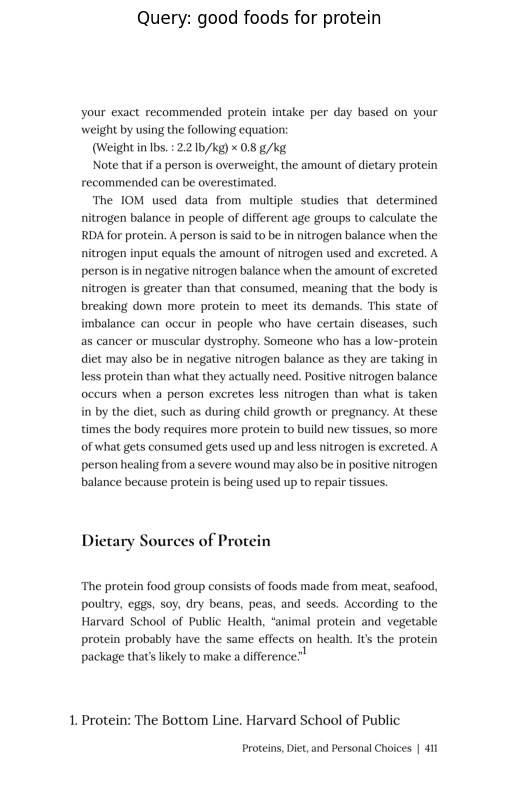

In [37]:
import fitz

# open PDF and load target
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(411 + 41)      # Adding 41 as the first 41 pages are not relevant

# Get the image of the page
img = page.get_pixmap(dpi=300)      # Higher the dpi, better image quality

doc.close()

# Convert pixmap to numpy array
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: {query}")
plt.axis("off")

### Similarity measures: dot product and cosine similarity

Closer vectors will have higher scores and vectors further away will have lower scores.

Vectors have direction (which way) and magnitude (how long is it?).

In [38]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example vectors/tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print(f"Dot product between vector1 and vector2: {dot_product(vector1, vector2)}")      # Large positive value as they're exactly the same
print(f"Dot product between vector1 and vector3: {dot_product(vector1, vector3)}")
print(f"Dot product between vector1 and vector4: {dot_product(vector1, vector4)}")      # Large negative value as they're exactly opposite

# Cosine similarity
print(f"Cosine similarity between vector1 and vector2: {cosine_similarity(vector1, vector2)}")      # 1 as they're exactly the same
print(f"Cosine similarity between vector1 and vector3: {cosine_similarity(vector1, vector3)}")      # High but less than 1 as they're similar but not the same
print(f"Cosine similarity between vector1 and vector4: {cosine_similarity(vector1, vector4)}")      # -1 as they're exactly opposite

Dot product between vector1 and vector2: 14.0
Dot product between vector1 and vector3: 32.0
Dot product between vector1 and vector4: -14.0
Cosine similarity between vector1 and vector2: 0.9999999403953552
Cosine similarity between vector1 and vector3: 0.9746317863464355
Cosine similarity between vector1 and vector4: -0.9999999403953552


### Functionalizing our semantic search pipeline

In [39]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.Tensor,
                                model: SentenceTransformer = embedding_model,
                                n_resources_to_retun: int = 5,
                                print_time: bool = True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings
    """

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot product scores on embeddings
    dot_scores = util.dot_score(query_embedding, embeddings)[0]

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_retun)
    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.Tensor,
                                 pages_and_chunks: list[dict] = pages_and_chunks,
                                 n_resources_to_return: int = 5):
    """
    Finds relevant passages given a query and print them out along with their scores
    """
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings, n_resources_to_retun=n_resources_to_return)

    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}\n")

In [40]:
query = "high fiber food"
retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

Score: 0.6717
Text:
• Change it up a bit and experience the taste and satisfaction of  other whole grains such as
barley, quinoa, and bulgur. • Eat snacks high in fiber, such as almonds, pistachios, raisins,  and
air-popped popcorn. Add an artichoke and green peas to your dinner plate more  276  |  Carbohydrates
and Personal Diet Choices
Page number: 276

Score: 0.6253
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples of soluble fibers
are inulin, pectin, and guar gum  and they are found in peas, beans, oats, barley, and rye.
Cellulose  and lignin are insoluble fibers and a few dietary sources of them  are whole-grain foods,
flax, cauliflower, and avocados. Cellulose is  the most abundant fiber in plants, making up the cell
walls and  providing structure. Soluble fibers are more easily accessible to  bacterial enzymes in
the large intestine so they can be broken down  to a greater extent than insoluble fibers, but even
some breakdown  of cellulose a

### Getting an LLM for local generation

We can use a LLM API, but as we're focused on local RAG, we will use a local LLM.

In [41]:
use_quantization_config = True              # Whether to quantize models
model_id = "google/gemma-2b-it"             # Which model to use

### Loading an LLM locally

To get a model running locally we need a few things:
1. A quantization config (optional) - A config on what precision to load the model in (e.g. 4 bit, 8 bit, etc.)
2. A model ID - This will tell transformers which model/tokenizer to load
3. A tokenizer - Turns texts into numbers ready for an LLM (not an embedding model)
4. An LLM model - this will be what we use to generate text based on an input!

In [47]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

use_quantization_config = True
HUGGINGFACE_HUB_TOKEN = "YOUR_TOKEN"
model_id = model_id

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    if torch.cuda.is_available() and use_quantization_config:
        # Define quantization configuration
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16
        )

        # Instantiate tokenizer
        tokenizer = AutoTokenizer.from_pretrained(
            pretrained_model_name_or_path=model_id,
            token=HUGGINGFACE_HUB_TOKEN
        )

        # Load model with quantization
        llm_model = AutoModelForCausalLM.from_pretrained(
            pretrained_model_name_or_path=model_id,
            torch_dtype=torch.float16,
            quantization_config=quantization_config,
            low_cpu_mem_usage=False,
            token=HUGGINGFACE_HUB_TOKEN
        )

    else:
        # Instantiate tokenizer
        tokenizer = AutoTokenizer.from_pretrained(
            pretrained_model_name_or_path=model_id,
            token=HUGGINGFACE_HUB_TOKEN
        )

        # Load model without quantization
        llm_model = AutoModelForCausalLM.from_pretrained(
            pretrained_model_name_or_path=model_id,
            torch_dtype=torch.float16,
            low_cpu_mem_usage=False,
            token=HUGGINGFACE_HUB_TOKEN
        )

    # Move model to the correct device
    llm_model.to(device)
    print("Model loaded and moved to device successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded and moved to device successfully.


In [48]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model param and buffer sizes
    mem_params = sum([param.numel() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.numel() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

In [49]:
get_model_mem_size(llm_model)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

### Generating Text with LLM

In [50]:
input_text = "What are micronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Manually format the prompt
prompt = ""
for message in dialogue_template:
    if message['role'] == 'user':
        prompt += f"User: {message['content']}\n"

# Optionally add a generation prompt if needed
prompt += "Assistant:"

print(f"\nFormatted prompt:\n{[[prompt]]}")

Input text:
What are micronutrients, and what roles do they play in the human body?

Formatted prompt:
[['User: What are micronutrients, and what roles do they play in the human body?\nAssistant:']]


In [51]:
# Tokenize the input text
input_ids = tokenizer(prompt,
                      return_tensors="pt").to(device)

# Generate outputs from local LM
outputs = llm_model.generate(**input_ids,           # ** means passing in the keys
                             max_new_tokens=256)
print(f"Model output tokens:\n{outputs[0]}")

Model output tokens:
tensor([     2,   2224, 235292,   2439,    708,  92800, 184592, 235269,    578,
          1212,  16065,    749,    984,   1554,    575,    573,   3515,   2971,
        235336,    108,  51190, 235292,  25479, 235269,   1517, 235303, 235256,
           476,  13367,    576,  92800, 184592,    578,   1024,  16065,    575,
           573,   3515,   2971, 235292,    109,    688,   5057,   1695, 184592,
           688,    708,   8727,  37132,    674,    573,   2971,   2952,   7872,
           611,   1277,   1997,    578,   2004,   9103,    774,    573,  11652,
        235265,   2365,   1554,    476,  20305,   4731,    575,   4282,  55786,
          7257, 235269,   3359, 235292,    109,    688, 235274, 235265,  10367,
          4584,  66058,    108, 235290, 180928, 184592,   1154,  23042,    599,
        235274, 235284, 235269, 231210, 235269,    578, 225523,    708,   6664,
           575,    573,   4584,    576,   4134,    575,   5999, 235265,    109,
           688, 235

In [52]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Decoded model output:\n{outputs_decoded}")

Decoded model output:
<bos>User: What are micronutrients, and what roles do they play in the human body?
Assistant: Sure, here's a summary of micronutrients and their roles in the human body:

**Micronutrients** are essential nutrients that the body cannot produce on its own and must obtain from the diet. They play a crucial role in various bodily functions, including:

**1. Energy production:**
- Micronutrients like vitamin B12, niacin, and folate are involved in the production of energy in cells.

**2. Red blood cell production:**
- Iron, found in red blood cells, is essential for oxygen transport.

**3. Bone health:**
- Calcium and phosphorus, found in dairy products and leafy greens, contribute to bone and tooth health.

**4. Immune function:**
- Vitamins A, C, and E support the immune system by protecting against infections.

**5. Metabolism:**
- Micronutrients like potassium, magnesium, and zinc are involved in regulating fluid balance, muscle function, and nerve signaling.

**6.

In [54]:
# Sample nutrition questions generated by GPT4
gpt4_q = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "What roles does fibre play in digestion? Name 5 fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created q list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_q + manual_questions

In [57]:
import random

query = random.choice(query_list)
print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

Query: How does saliva help with digestion?


### Augmenting our prompt with context items

Now that we're done with retrieval and generation, let's focus on the augmentation part of RAG.

The concept of augmenting a prompt with context items is also referred as prompt engineering.

We're going to use a couple of techniques:
1. Give clear instructions.
2. Give a few examples of input/output (few shot prompting)
3. Give room to think (e.g. create a scratchpad/show your working/let's go step by step)

In [115]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:

                     context = " - " + "\n- ".join([item["sentence_chunk"] for item in context_items])
                     base_prompt = """Based on the following context items, please answer the query.
                     Give yourself room to think by extracting relevant passages from the context before answering the query.
                     Don't return the thinking, only return the answer.
                     Make sure your answers are as explanatory as possible.
                     Use the following examples as reference (and only for reference) for the ideal answer style.
                     \nExample 1:
                     Query: What are the fat-soluble vitamins?
                     Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
                     \nExample 2:
                     Query: What are the causes of type 2 diabetes?
                     Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
                     \nExample 3:
                     Query: What is the importance of hydration for physical performance?
                     Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
                     \nNow use the following context items to answer the user query:
                     {context}
                     \nRelevant passages: <extract relevant passages from the context here>
                     User query: {query}
                     Answer:"""
                     prompt = base_prompt.format(context=context, query=query)

                     # Create prompt template for instruction tuned model
                     dialogue_template = [
                         {'role': 'user',
                          'content': base_prompt,}
                     ]

                     # Apply the chat template
                     prompt = tokenizer.apply_chat_template(conversation=dialogue_template, tokenize=False, add_generation_prompt=False)
                     return prompt

query = random.choice(query_list)
print(f"Query:{query}")

# Get relevant resources
sources, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query=query, context_items=context_items)
prompt

Query:How do vitamins and minerals differ in their roles and importance for health?


"<bos><start_of_turn>user\nBased on the following context items, please answer the query.\n                     Give yourself room to think by extracting relevant passages from the context before answering the query.\n                     Don't return the thinking, only return the answer.\n                     Make sure your answers are as explanatory as possible.\n                     Use the following examples as reference (and only for reference) for the ideal answer style.\n                     \nExample 1:\n                     Query: What are the fat-soluble vitamins?\n                     Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecti

In [116]:
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7,         # Higher the value, the more creative is the text
                             do_sample=True,          # Whether or not to use sampling
                             max_new_tokens=256)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG Answer:\n{output_text.replace(prompt, '')}")        # Getting the RAG answer and removing the prompt from it

Query: How do vitamins and minerals differ in their roles and importance for health?
RAG Answer:
<bos>                     

Please note that the context does not provide any information about the query, so I cannot generate the answer from the context.<eos>


### Functionize our LLM answering feature

Input -> Query
Output -> Generated Answer + Source Documents (optional)

In [128]:
def ask(query,
        temperature=0.7,
        max_new_tokens=1024,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()   # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(query, "").replace("<bos>", "").replace("<eos>", "").replace("<start_of_turn>", "").replace("user\nBased on the following context items, please answer the query.\n                     Give yourself room to think by extracting relevant passages from the context before answering the query.\n                     Don't return the thinking, only return the answer.\n                     Make sure your answers are as explanatory as possible.\n                     Use the following examples as reference for the ideal answer style.\n                     \nExample 1:\n                     Query: What are the fat-soluble vitamins?\n                     Answer: ", "").replace("user\nBased on the following context items, please answer the query.\n                     Give yourself room to think by extracting relevant passages from the context before answering the query.\n                     Don't return the thinking, only return the answer.\n                     Make sure your answers are as explanatory as possible.\n                     Use the following examples as reference (and only for reference) for the ideal answer style.\n                     \nExample 1:\n                     ", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [129]:
query = random.choice(query_list)
ask(query=query)

"Query: What are the fat-soluble vitamins?\n                     Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.\n                     \nExample 2:\n                     Query: What are the causes of type 2 diabetes?\n                     Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancr

In [130]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: How do vitamins and minerals differ in their roles and importance for health?
Answer:

Query: What are the fat-soluble vitamins?                      Answer: The fat-soluble vitamins
include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats
in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is
important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium
absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin
K is essential for blood clotting and bone metabolism.                       Example 2:
Query: What are the causes of type 2 diabetes?                      Answer: Type 2 diabetes is often
associated with overnutrition, particularly the overconsumption of calories leading to obesity.
Factors include a diet high in refined sugars and saturated fats, which can lead to insulin
resistance, a condition where the body'

{'page_number': 11,
 'sentence_chunk': 'Vitamins  Major Functions  Water-soluble  Thiamin (B1)  Coenzyme, energy metabolism assistance  Riboflavin (B2 )  Coenzyme, energy metabolism assistance  Niacin (B3)  Coenzyme, energy metabolism assistance  Pantothenic acid  (B5)  Coenzyme, energy metabolism assistance  Pyridoxine (B6)  Coenzyme, amino acid synthesis assistance  Biotin (B7)  Coenzyme, amino acid and fatty acid metabolism  Folate (B9)  Coenzyme, essential for growth  Cobalamin (B12)  Coenzyme, red blood cell synthesis  C (ascorbic acid)  Collagen synthesis, antioxidant  Fat-soluble  A  Vision, reproduction, immune system function  D  Bone and teeth health maintenance, immune system  function  E  Antioxidant, cell membrane protection  K  Bone and teeth health maintenance, blood clotting  Vitamin deficiencies can cause severe health problems and even  death. For example, a deficiency in niacin causes a disease called  pellagra, which was common in the early twentieth century in some